# 05 — Experimento Extra (XGBoost + Features Técnicas)

Apenas verificando se consigo melhorar a performance adicionando features técnicas e testando XGBoost.
- RSI, médias móveis exponenciais, bandas de Bollinger, volatilidade.
- TimeSeriesSplit (CV temporal).
- Comparativo com Random Forest / HGB.

In [5]:
import sys
!{sys.executable} -m pip install xgboost --upgrade --quiet

In [6]:
%matplotlib inline
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook")

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

In [7]:
# Carregamento do dataset processado e separação de X/y
root = Path('.')
in_path = root / 'data' / 'processed' / 'ibov_features.parquet'
df = pd.read_parquet(in_path)
y = df['target_next_day_up']
X = df.drop(columns=['target_next_day_up']).copy()
print('Shape original:', X.shape, y.shape)
print('Última data:', df.index.max().date())

Shape original: (3870, 24) (3870,)
Última data: 2025-09-12


In [8]:
# Features técnicas adicionais
def add_tech_features(df):
    df = df.copy()
    
    # RSI (14)
    delta = df['ultimo'].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    rs = roll_up / (roll_down + 1e-9)
    df['RSI14'] = 100 - (100 / (1 + rs))
    
    # Médias móveis exponenciais
    df['EMA_10'] = df['ultimo'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['ultimo'].ewm(span=20, adjust=False).mean()
    
    # Bandas de Bollinger (20)
    ma20 = df['ultimo'].rolling(20).mean()
    std20 = df['ultimo'].rolling(20).std()
    df['Boll_up'] = ma20 + 2*std20
    df['Boll_dn'] = ma20 - 2*std20
    
    # Volatilidade realizada (20)
    df['vol20'] = df['return_d1'].rolling(20).std()
    
    return df

X_extra = add_tech_features(X)
X_extra = X_extra.fillna(0)
print('Shape com features extras:', X_extra.shape)

Shape com features extras: (3870, 30)


In [9]:
# ==== Split temporal (últimos 30 dias = teste) ====
TEST_SIZE = 30
X_train, X_test = X_extra.iloc[:-TEST_SIZE], X_extra.iloc[-TEST_SIZE:]
y_train, y_test = y.iloc[:-TEST_SIZE], y.iloc[-TEST_SIZE:]
print('Split treino/teste:', X_train.shape, X_test.shape)

Split treino/teste: (3840, 30) (30, 30)


In [10]:
# XGBoost tuning + treino
tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

search = RandomizedSearchCV(xgb_model, param_grid, n_iter=20, cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)
search.fit(X_train, y_train)
print('XGB — melhor score CV:', search.best_score_)
print('XGB — melhores params:', search.best_params_)
xgb_best = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGB — melhor score CV: 0.515
XGB — melhores params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


XGBoost — Acurácia teste: 50.00%
              precision    recall  f1-score   support

           0       0.50      0.80      0.62        15
           1       0.50      0.20      0.29        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.45        30
weighted avg       0.50      0.50      0.45        30



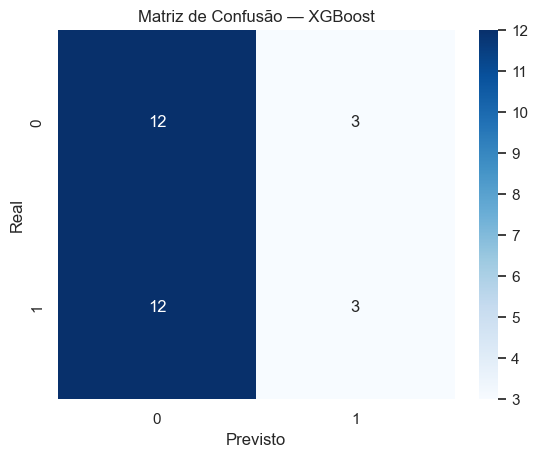

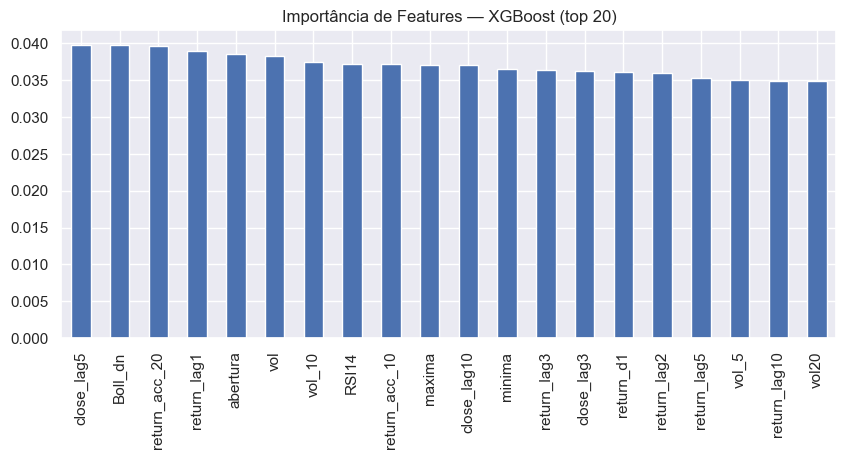

In [11]:
# Avaliação no teste
y_proba = xgb_best.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost — Acurácia teste: {acc:.2%}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão — XGBoost')
plt.xlabel('Previsto'); plt.ylabel('Real'); plt.show()

imp = pd.Series(xgb_best.feature_importances_, index=X_extra.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,4))
imp.plot(kind='bar')
plt.title('Importância de Features — XGBoost (top 20)')
plt.show()